# Link Deletion
example notebook demonstrating link deletion

In [1]:
import os

In [2]:
os.environ["DGLBACKEND"] = "pytorch"

In [3]:
import torch 
import pandas as pd
import dgl
from dgl.data import DGLDataset
import dgl.function as fn
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

## Import toy graph data

In [4]:
ds = dgl.data.CSVDataset('./DGL_playground/toy_dataset/')

Done loading data from cached files.


In [5]:
g = ds[0]

In [6]:
g.edata['w'] = torch.rand(g.num_edges(),1)

In [7]:
g.edges(form='all')

(tensor([0, 0, 0, 1, 1, 2, 2, 3, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8]),
 tensor([1, 2, 3, 0, 2, 0, 1, 0, 4, 5, 3, 5, 3, 4, 7, 8, 6, 8, 6, 7]),
 tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19]))

### visualize graph 

In [8]:
def plot_net(net,options = None):
    netG = dgl.to_networkx(net)
    plt.figure(figsize=[15,7])
    if options != None:
        nx.draw(netG,**options)
    else:
        nx.draw(netG)

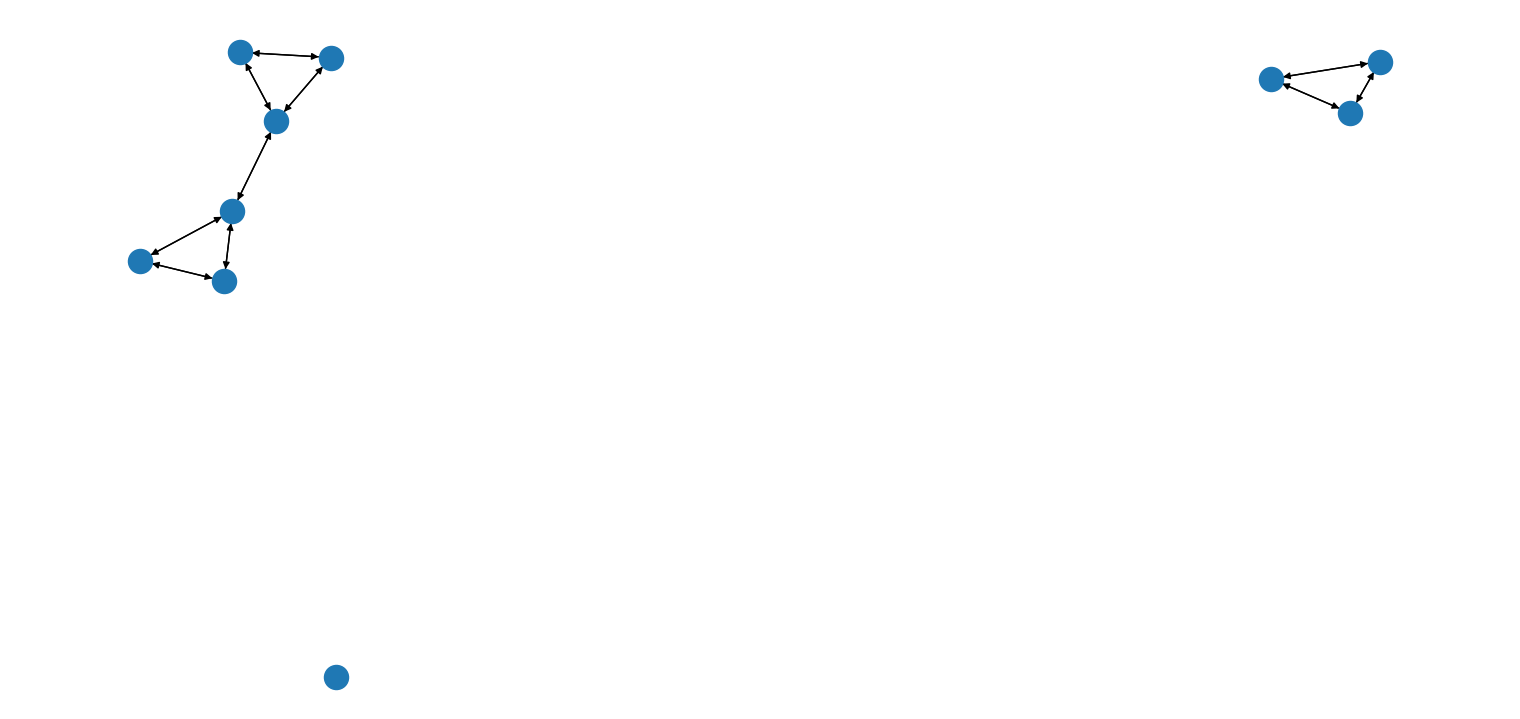

In [9]:
plot_net(g)

## Select (bidirectional) edges for deletion using adjacency matrix
Since all edges in the considered graph are bidirectional the adjcency matrix is symmetrical. Accordingly, edges for deletion can be selected on the upper (or lower) tringular matrix of the adjacency matrix with the row and column coordinates `i,j` indicating `src` and `dst` nodes.

Once links for deletion have been selected the reverse direction cn be added by adding the transpose.

Edges are identified for deletion by comparison of a uniformly distriibuuted random number with a preset deletion probability

Here we make use of the fact that the values on the non-zero elements of the adjacency matrix default to `0`. This could also make use of a prroperty (as retrieved in the `adj_mat_with_edge_prop()`)

In [10]:
adj = g.adj()

In [11]:
adj

SparseMatrix(indices=tensor([[0, 0, 0, 1, 1, 2, 2, 3, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8],
                             [1, 2, 3, 0, 2, 0, 1, 0, 4, 5, 3, 5, 3, 4, 7, 8, 6, 8, 6, 7]]),
             values=tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                            1., 1.]),
             shape=(10, 10), nnz=20)

In [12]:
#select the upper triangular matrix from a sparse matrix
def triu(spm):
    mask = spm.row <= spm.col
    return dgl.sparse.from_coo(spm.row[mask],spm.col[mask],spm.val[mask],shape=spm.shape)

In [13]:
#create a symmetrical matrix based on an input upper triangular matrix. Note, this works because the diagonal is zero as we have no self-loops  
def sym_from_triu(triuspm):
    return triuspm + triuspm.T

In [23]:
#apply mask to sparse matrix 
def sparse_from_mask(om, mask):
    return dgl.sparse.from_coo(om.row[mask],om.col[mask],om.val[mask],shape=om.shape)

In [15]:
deletion_probability = 0.3

In [16]:
triu_adj = triu(adj)

In [17]:
selection_values = triu_adj.val*torch.rand(triu_adj.val.size()[0])

In [18]:
selection_values

tensor([0.0142, 0.0272, 0.8709, 0.9453, 0.6398, 0.0332, 0.7769, 0.1201, 0.0449,
        0.7088])

In [19]:
del_links = selection_values < deletion_probability

In [24]:
triu_adj_del = sparse_from_mask(triu_adj,del_links)

In [26]:
sym_triu_adj_del = sym_from_triu(triu_adj_del)


### Obtaining edge ids from row and column numbers 

In [30]:
deledge_ids = g.edge_ids(sym_triu_adj_del.row,sym_triu_adj_del.col)  

In [31]:
g.remove_edges(deledge_ids)

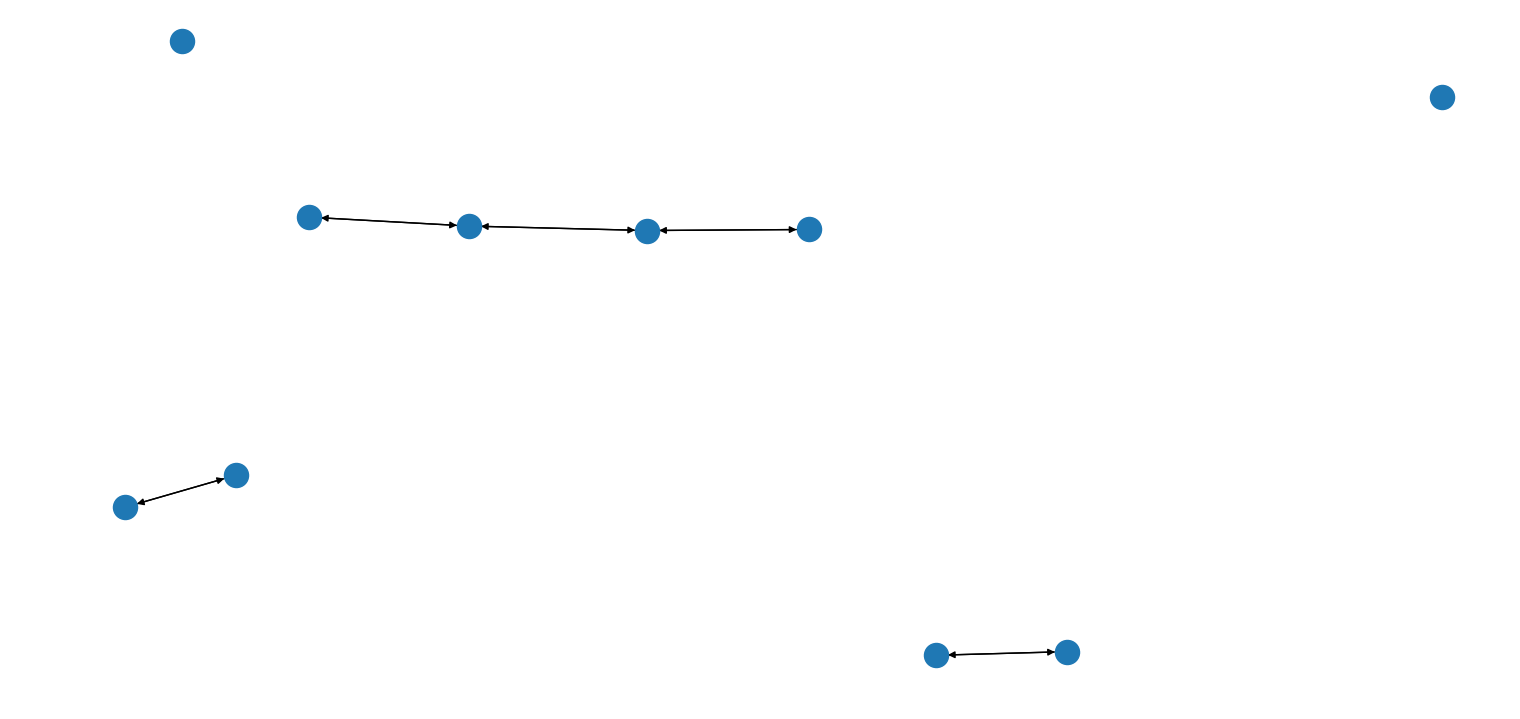

In [32]:
plot_net(g)